# Deep Kalman Filter

- [https://arxiv.org/pdf/1511.05121.pdf](https://arxiv.org/pdf/1511.05121.pdf)

- [https://arxiv.org/pdf/1609.09869.pdf](https://arxiv.org/pdf/1609.09869.pdf)

- DKFDynamicSystem class:  
[https://github.com/Google-Health/records-research/blob/master/state-space-model/models.py](https://github.com/Google-Health/records-research/blob/master/state-space-model/models.py)

- MultivariateNormal:  
[https://pytorch.org/docs/stable/distributions.html](https://pytorch.org/docs/stable/distributions.html)

In [8]:
import copy
import pandas as pd
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal

## Model
### GatedTransition

Used when computing prior probability

In [9]:
class GatedTransition(nn.Module):
    def __init__(self, z_dim, hid_dim):
        super(GatedTransition, self).__init__()

        self.gate = nn.Sequential(nn.Linear(z_dim, hid_dim),
                                  nn.ReLU(),
                                  nn.Linear(hid_dim, z_dim),
                                  nn.Sigmoid())

        self.proposed_mean = nn.Sequential(nn.Linear(z_dim, hid_dim),
                                           nn.ReLU(),
                                           nn.Linear(hid_dim, z_dim))

        self.z_to_mu = nn.Linear(z_dim, z_dim)
        # modify the default initialization of z_to_mu
        # so that it starts out as the identity function
        self.z_to_mu.weight.data = torch.eye(z_dim)
        self.z_to_mu.bias.data = torch.zeros(z_dim)

        self.z_to_logvar = nn.Linear(z_dim, z_dim)
        self.relu = nn.ReLU()

    def forward(self, z_t_1):
        # 
        gate = self.gate(z_t_1)
        proposed_mean = self.proposed_mean(z_t_1)
        mu = (1 - gate) * self.z_to_mu(z_t_1) + gate * proposed_mean
        logvar = self.z_to_logvar(self.relu(proposed_mean))
        # sampling
        eps = torch.randn(z_t_1.size())
        z_t = mu + eps * torch.exp(.5 * logvar)
        return z_t, mu, logvar

### Combiner

Used when computing posterior probability

In [10]:
class Combiner(nn.Module):
    # PostNet
    def __init__(self, z_dim, hid_dim):
        super(Combiner, self).__init__()
        self.z_dim = z_dim
        self.z_to_hidden = nn.Linear(z_dim, hid_dim)
        self.hidden_to_mu = nn.Linear(hid_dim, z_dim)
        self.hidden_to_logvar = nn.Linear(hid_dim, z_dim)
        self.tanh = nn.Tanh()

    def forward(self, z_t_1, h_rnn):
        # combine the rnn hidden state with a transformed version of z_t_1
        h_combined = 0.5 * (self.tanh(self.z_to_hidden(z_t_1)) + h_rnn)
        # use the combined hidden state
        # to compute the mean used to sample z_t
        mu = self.hidden_to_mu(h_combined)
        # use the combined hidden state
        # to compute the scale used to sample z_t
        logvar = self.hidden_to_logvar(h_combined)
        eps = torch.randn(z_t_1.size())
        z_t = mu + eps * torch.exp(.5 * logvar)
        return z_t, mu, logvar

### Emitter

In [11]:
class Emitter(nn.Module):
    def __init__(self, z_dim, hid_dim, input_dim) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.z_to_hidden = nn.Linear(z_dim, hid_dim)
        self.hidden_to_hidden = nn.Linear(hid_dim, hid_dim)
        self.hidden_to_input_mu = nn.Linear(hid_dim, input_dim)
        self.logvar = nn.Parameter(torch.ones(input_dim))
        self.relu = nn.ReLU()

    def forward(self, z_t):
        h1 = self.relu(self.z_to_hidden(z_t))
        h2 = self.relu(self.hidden_to_hidden(h1))
        mu = self.hidden_to_input_mu(h2)
        # return mu  # x_t
        eps = torch.randn(z_t.size(0), self.input_dim)
        x_t = mu + eps * torch.exp(.5 * self.logvar)
        return x_t, mu, self.logvar


In [12]:
class Encoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        

### Main class

- [encoder](https://github.com/Google-Health/records-research/blob/8e8f2a1d9b7717670d6125155db038c048d67d53/state-space-model/models.py#L819)

In [54]:
class DKF(nn.Module):
    # Structured Inference Networks
    # Current version ignores backward RNN outputs
    def __init__(self, input_dim, z_dim=50, trans_dim=30, emission_dim=30,
                 rnn_dim=100, num_rnn_layers=1) -> None:

        super().__init__()
        self.input_dim = input_dim
        self.z_dim = z_dim
        self.trans_dim = trans_dim
        self.emission_dim = emission_dim
        self.rnn_dim = rnn_dim
        self.num_rnn_layers = num_rnn_layers

        self.trans = GatedTransition(z_dim, trans_dim)
        self.emitter = Emitter(z_dim, emission_dim, input_dim)
        self.combiner = Combiner(z_dim, rnn_dim)

        self.z_0 = nn.Parameter(torch.zeros(z_dim))
        self.z_q_0 = nn.Parameter(torch.zeros(z_dim))
        self.h_0 = nn.Parameter(torch.zeros(1, 1, rnn_dim))

        # corresponding learning 'l' in the original code
        self.rnn = nn.LSTM(input_size=input_dim,
                          hidden_size=rnn_dim,
                        #   nonlinearity="relu",
                          batch_first=True,
                          bidirectional=False,
                          num_layers=num_rnn_layers)

        # self.rnn = nn.RNN(input_size=input_dim,
        #                   hidden_size=rnn_dim,
        #                   nonlinearity="relu",
        #                   batch_first=True,
        #                   bidirectional=False,
        #                   num_layers=num_rnn_layers)

    def kl_div(self, mu1, logvar1, mu2=None, logvar2=None):

        if mu2 is None:
            mu2 = torch.zeros(1, device=mu1.device)

        if logvar2 is None:
            logvar2 = torch.zeros(1, device=mu1.device)

        return torch.sum(0.5 * (
            logvar2 - logvar1 + (torch.exp(logvar1) + (mu1 - mu2).pow(2))
            / torch.exp(logvar2) - torch.ones(1, device=mu1.device)
        ), 1)

    def infer(self, x):
        
        batch_size, T_max, x_dim = x.size()
        h_0 = self.h_0.expand(1, batch_size, self.rnn_dim).contiguous()
        rnn_out, h_n = self.rnn(x, h_0)

        z_prev = self.z_q_0.expand(batch_size, self.z_q_0.size(0))
        kl_states = torch.zeros((batch_size, T_max))
        rec_losses = torch.zeros((batch_size, T_max))

        for t in range(T_max):
            # p(z_t|z_{t-1})
            z_prior, z_prior_mu, z_prior_logvar = self.trans(z_prev)
            # q(z_t|z_{t-1},x_{t:T})
            z_t, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, t])
            # p(x_t|z_t)
            x_t, x_mu, x_logvar = self.emitter(z_t)

            # compute loss
            kl_states[:, t] = self.kl_div(
                z_mu, z_logvar, z_prior_mu, z_prior_logvar)
            rec_losses[:, t] = nn.MSELoss(reduction='none')(
                x_t.contiguous().view(-1),
                # x_mu.contiguous().view(-1),
                x[:, t].contiguous().view(-1)
            ).view(batch_size, -1).mean(dim=1)

            z_prev = z_t

        return rec_losses.mean(), kl_states.mean()

    def filter(self, x, num_sample=100):

        # Outputs
        x_hat = torch.zeros(x.size())  # predictions
        x_025 = torch.zeros(x.size())
        x_975 = torch.zeros(x.size())

        batch_size, T_max, x_dim = x.size()
        assert batch_size == 1
        z_prev = self.z_0.expand(num_sample, self.z_0.size(0))

        h_0 = self.h_0.expand(1, 1, self.rnn_dim).contiguous()
        rnn_out, _ = self.rnn(x, h_0)
        rnn_out = rnn_out.expand(num_sample,
            rnn_out.size(1), rnn_out.size(2))

        for t in range(T_max):
            # z_t: (num_sample, z_dim)
            z_t, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, t])
            x_t, x_mu, x_logvar = self.emitter(z_t)
            # x_hat[:, t] = x_mu

            x_covar = torch.diag(torch.sqrt(torch.exp(.5 * x_logvar)))
            x_samples = MultivariateNormal(
                x_mu, covariance_matrix=x_covar).sample()
            # # sampling z_t and computing quantiles
            # x_samples = MultivariateNormal(
            #     loc=x_mu, covariance_matrix=x_covar).sample_n(num_sample)

            x_hat[:, t] = x_samples.mean(0)
            x_025[:, t] = x_samples.quantile(0.025, 0)
            x_975[:, t] = x_samples.quantile(0.975, 0)

            # x_hat[:, t] = x_t.mean(0)
            # x_025[:, t] = x_t.quantile(0.025, 0)
            # x_975[:, t] = x_t.quantile(0.975, 0)

            z_prev = z_t
            # z_prev = z_mu

        return x_hat, x_025, x_975

    def predict(self, x, pred_steps=1, num_sample=100, step_by_step=True):
        """ x should contain the prediction period
        """
        # Outputs
        x_hat = torch.zeros(x.size())  # predictions
        x_025 = torch.zeros(x.size())
        x_975 = torch.zeros(x.size())

        batch_size, T_max, x_dim = x.size()
        assert batch_size == 1
        z_prev = self.z_0.expand(num_sample, self.z_0.size(0))

        if not step_by_step:
            # hide test inputs
            x = copy.deepcopy(x)
            x[:, -pred_steps:] = 0.

        h_0 = self.h_0.expand(1, 1, self.rnn_dim).contiguous()
        rnn_out, _ = self.rnn(x[:, :T_max-pred_steps], h_0)
        rnn_out = rnn_out.expand(num_sample,
            rnn_out.size(1), rnn_out.size(2))

        for t in range(T_max - pred_steps):
            # z_t: (num_sample, z_dim)
            z_t, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, t])
            x_t, x_mu, x_logvar = self.emitter(z_t)

            x_covar = torch.diag(torch.sqrt(torch.exp(.5 * x_logvar)))
            x_samples = MultivariateNormal(
                x_mu, covariance_matrix=x_covar).sample()

            x_hat[:, t] = x_samples.mean(0)
            x_025[:, t] = x_samples.quantile(0.025, 0)
            x_975[:, t] = x_samples.quantile(0.975, 0)

            z_prev = z_mu

        for t in range(T_max - pred_steps, T_max):
            rnn_out, _ = self.rnn(x[:, :t], h_0)
            rnn_out = rnn_out.expand(
                num_sample, rnn_out.size(1), rnn_out.size(2))

            z_t_1, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, -1])
            z_t, z_mu, z_logvar = self.trans(z_t_1)
            x_t, x_mu, x_logvar = self.emitter(z_t)

            x_covar = torch.diag(torch.sqrt(torch.exp(.5 * x_logvar)))
            x_samples = MultivariateNormal(
                x_mu, covariance_matrix=x_covar).sample()

            x_hat[:, t] = x_samples.mean(0)
            x_025[:, t] = x_samples.quantile(0.025, 0)
            x_975[:, t] = x_samples.quantile(0.975, 0)

        return x_hat, x_025, x_975

    def forecast(self, x, forecast_steps, num_sample=100):
        # Outputs
        x_hat = torch.zeros(x.size())  # predictions
        x_025 = torch.zeros(x.size())
        x_975 = torch.zeros(x.size())

        batch_size, T_max, x_dim = x.size()
        assert batch_size == 1
        z_prev = self.z_0.expand(num_sample, self.z_0.size(0))

        h_0 = self.h_0.expand(1, 1, self.rnn_dim).contiguous()
        rnn_out, _ = self.rnn(x, h_0)
        rnn_out = rnn_out.expand(num_sample,
            rnn_out.size(1), rnn_out.size(2))

        # encoding a training sequence
        for t in range(T_max):
            # z_t: (num_sample, z_dim)
            z_t, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, t])
            x_t, x_mu, x_logvar = self.emitter(z_t)

            x_covar = torch.diag(torch.sqrt(torch.exp(.5 * x_logvar)))
            x_samples = MultivariateNormal(
                x_mu, covariance_matrix=x_covar).sample()

            x_hat[:, t] = x_samples.mean(0)
            x_025[:, t] = x_samples.quantile(0.025, 0)
            x_975[:, t] = x_samples.quantile(0.975, 0)

            z_prev = z_mu

        # generating a future sequence
        for t in range(T_max, T_max+forecast_steps):
            rnn_out, _ = self.rnn(x[:, :t], h_0)
            rnn_out = rnn_out.expand(
                num_sample, rnn_out.size(1), rnn_out.size(2))

            z_t_1, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, -1])
            z_t, z_mu, z_logvar = self.trans(z_t_1)
            x_t, x_mu, x_logvar = self.emitter(z_t)

            x_covar = torch.diag(torch.sqrt(torch.exp(.5 * x_logvar)))
            x_samples = MultivariateNormal(
                x_mu, covariance_matrix=x_covar).sample()

            x_hat[:, t] = x_samples.mean(0)
            x_025[:, t] = x_samples.quantile(0.025, 0)
            x_975[:, t] = x_samples.quantile(0.975, 0)

        return x_hat, x_025, x_975

    def train_step(self, x, annealing_factor=0.1):
        self.train()
        # self.rnn.train()
        rec_loss, kl_loss = self.infer(x)
        total_loss = rec_loss + annealing_factor * kl_loss
        self.optimizer.zero_grad()
        total_loss.backward()
        # nn.utils.clip_grad_norm_(self.parameters(), 5.)
        self.optimizer.step()
        return rec_loss.item(), kl_loss.item(), total_loss.item()

    def validation_step(self, x, annealing_factor=0.1):
        self.eval()
        rec_loss, kl_loss = self.infer(x)
        total_loss = rec_loss + annealing_factor * kl_loss
        return rec_loss.item(), kl_loss.item(), total_loss.item()

    def fit(self, x, x_val=None, num_epochs=100, annealing_factor=0.1,
            verbose_step=1, eval_step=1, check_point_path=None,
            patience=20, learning_rate=0.01):

        self.optimizer = torch.optim.Adam(
            self.parameters(), lr=learning_rate)

        losses = []
        kl_losses = []
        rec_losses = []
        val_losses = []
        val_kl_losses = []
        val_rec_losses = []

        for epoch in range(num_epochs):
            try:
                res = self.train_step(x, annealing_factor=annealing_factor)
                losses.append(res[2])
                kl_losses.append(res[1])
                rec_losses.append(res[0])

                if epoch % verbose_step == verbose_step - 1:
                    message =  f'Epoch= {epoch+1}/{num_epochs}, '
                    message += f'loss= {res[2]:.3f}, '
                    message += f'mse= {res[0]:.3f}, '
                    message += f'kld= {res[1]:.3f}'
                    print(message)

                if x_val is not None:
                    val_res = self.validation_step(x_val, annealing_factor)
                    val_losses.append(val_res[2])
                    val_kl_losses.append(val_res[1])
                    val_rec_losses.append(val_res[0])

                if epoch % eval_step == eval_step - 1 and x_val is not None:
                    message = f'\tval_loss= {val_res[2]:.3f}, '
                    message += f'val_mse= {val_res[0]:.3f}, '
                    message += f'val_kld= {val_res[1]:.3f}'
                    print(message)

            except KeyboardInterrupt:
                break
        
        history = {'loss': losses,
                   'kl_loss': kl_losses,
                   'rec_loss': rec_losses}

        if x_val is not None:
            history.update({'val_loss': val_losses,
                            'val_kl_loss': val_kl_losses,
                            'val_rec_loss': val_rec_losses})

        return history

    def save_model(self, filename):
        """ dkf.pth """
        torch.save(self.to('cpu').state_dict(), filename)
    
    def load_model(self, filename):
        self.load_state_dict(torch.load(filename))

    def get_config(self):
        return {
            'input_dim': self.input_dim,
            'z_dim': self.z_dim,
            'trans_dim': self.trans_dim,
            'emission_dim': self.emission_dim,
            'rnn_dim': self.rnn_dim,
            'num_rnn_layers': self.num_rnn_layers
        }

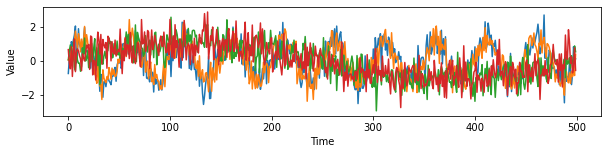

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import scale
# import warnings
# warnings.filterwarnings('ignore')

T = 500  # sequence length
observations = 2*np.sin(np.linspace(0, 20*np.pi, T))
interventions = 2*np.sin(np.linspace(0, 2*np.pi, T))
data = np.vstack([observations, observations*1.2, interventions, interventions*0.85]).T
data += np.random.randn(*data.shape)
# data[:, 2:] = preprocessing.minmax_scale(data[:, 2:])
data = scale(data)

plt.figure(figsize=(10, 2))
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [56]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])

In [57]:
dkf = DKF(input_dim=4, z_dim=20, rnn_dim=20, trans_dim=20, emission_dim=10)

In [58]:
history = dkf.fit(x_train, x_val, num_epochs=50, annealing_factor=0.05)

RuntimeError: Expected hidden[0] size (1, 1, 20), got [1, 20]

<AxesSubplot:xlabel='Epoch'>

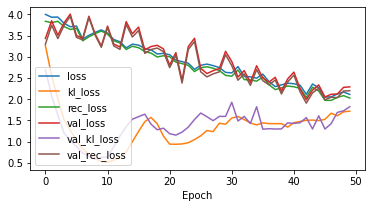

In [47]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

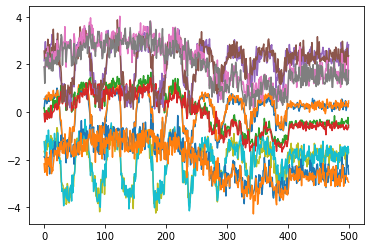

In [48]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
# x_hat, x_025, x_975 = dkf.predict(x, 100)
x_hat, x_025, x_975 = dkf.predict(x, 100, step_by_step=False)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

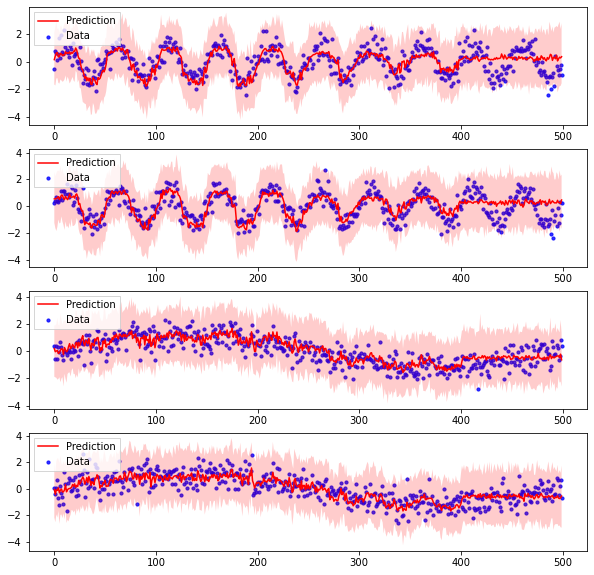

In [49]:
fig, ax = plt.subplots(4, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                     facecolor='r', alpha=0.2)
    axi.legend(loc='upper left', fancybox=False)

plt.show()
